In [1]:
from PIL import Image
from skimage.io import imread
from skimage.transform import rescale, resize
import os
import glob
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras import applications
import keras
from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
import seaborn as sn

Using TensorFlow backend.


In [2]:
path  = "/kaggle/input/blnwimages224/blnw-images-224"
os.chdir(path)
category_list=os.listdir(path)
category_list

['nut', 'locatingpin', 'bolt', 'washer']

In [3]:
list_of_image = glob.glob("**/*.png")
list_of_folders = glob.glob("**")
print("Total number of files " + str(len(list_of_image)) )#Total data
print("Total Number of classes "+ str(len(list_of_folders))) #Total Number of classes|

Total number of files 7616
Total Number of classes 4


In [4]:
#INDEX for Class number and Serial Number
Class_Dict = {}
for i in range(len(list_of_folders)):
    Class_Dict[i] = list_of_folders[i] 

Class_Dict

{0: 'nut', 1: 'locatingpin', 2: 'bolt', 3: 'washer'}

In [5]:
# Converts the class type into integers according to their order in the folder
# and appends to the list Y_list
Y_list = []
for i, data in enumerate(list_of_folders,0):
    list_of_images_in_folder = glob.glob(data+"/*.png") #check for .JPEG or .jpg or .png
    for j in list_of_images_in_folder:
        Y_list.append(i)

Y = np.asarray(Y_list)
Y = Y.reshape(-1,1)
Y.shape

(7616, 1)

In [8]:
# to Count the number of files in each category(i.e. folder). 
# Compare with number of files in the folder.
np.unique(Y)
unique, counts = np.unique(Y, return_counts=True)
dict(zip(unique, counts)) 

{0: 1904, 1: 1904, 2: 1904, 3: 1904}

In [9]:
image_list = []
for i,each in enumerate(list_of_image,1):
    im = imread(each, as_gray = True) #Convert images to gray and read as an array 
    image_list.append(im) #add to this list

In [10]:
X = np.asarray(image_list) #Convert the list into array
X.shape

(7616, 224, 224)

In [11]:
X_ref = X #To keep the dimensions
X = X.reshape(-1, X_ref.shape[1],X_ref.shape[2], 1) #Convert to format usable by our model
X.shape

(7616, 224, 224, 1)

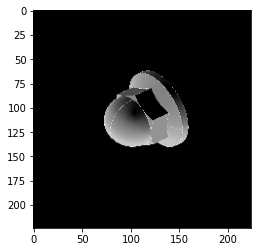

In [12]:
#Visualise an image 
plt.imshow(X[0].reshape(X_ref.shape[1],X_ref.shape[2]), cmap = plt.cm.binary)
plt.show()

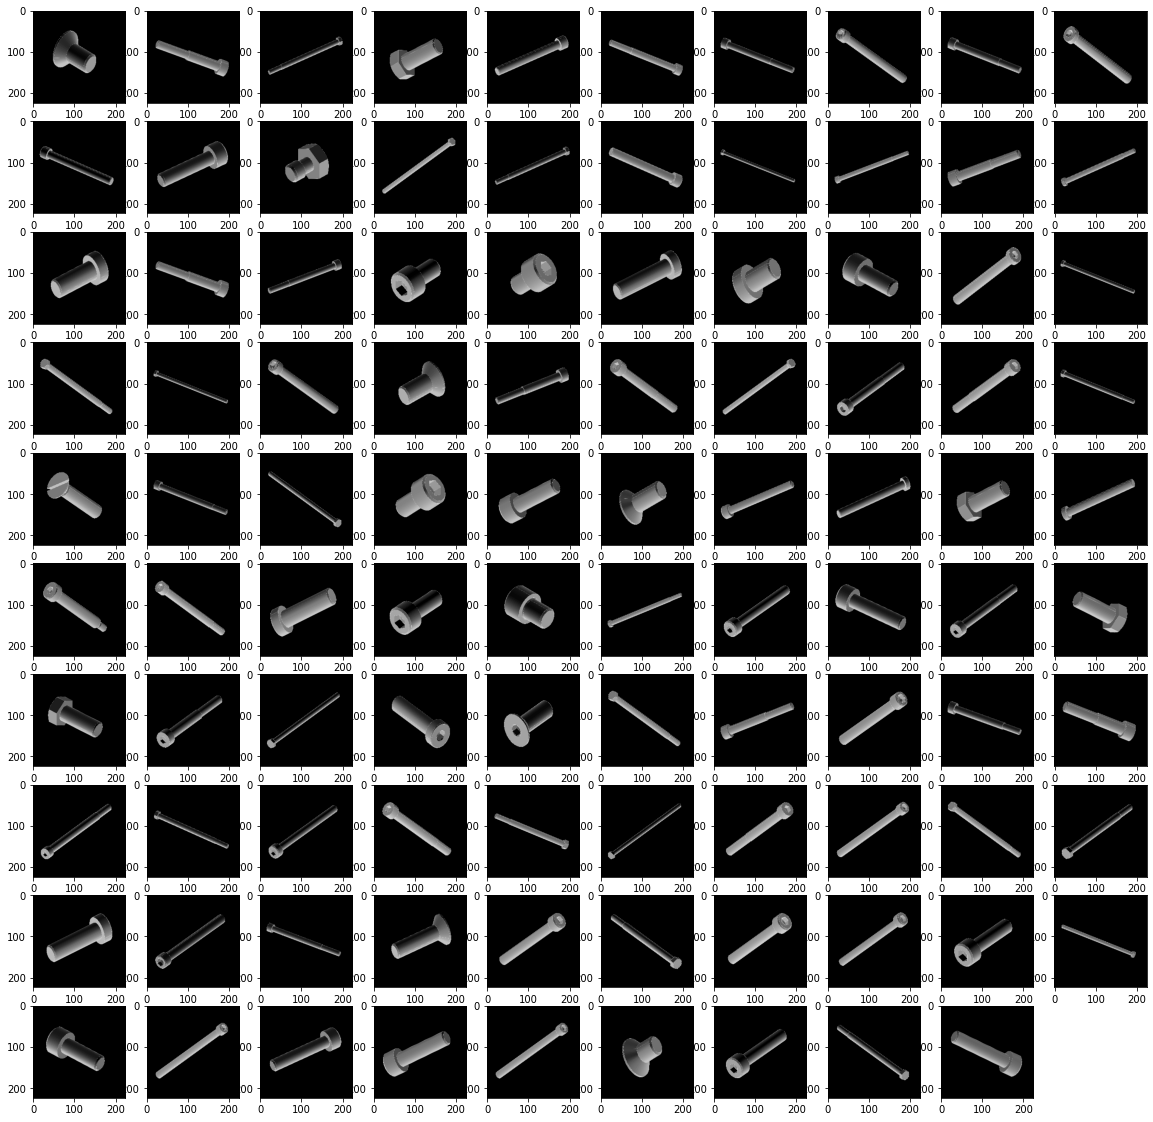

In [15]:
#Visualisation for classes
plt.figure(figsize=(20,20));
n = 2 #Class number {0: 'nut', 1: 'locatingpin', 2: 'bolt', 3: 'washer'}
num = 100 #num of data to visualize from the cluster
for i in range(1,num): 
    plt.subplot(10, 10, i); #(Number of rows, Number of column per row, item number)
    plt.imshow(X[i+(1904*n)].reshape(X.shape[1], X.shape[2]), cmap = plt.cm.binary);
    
plt.show()

In [16]:
#Training split
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.8,test_size=0.2, random_state=1) 

In [17]:
print("Shape of training data " + str(X_train.shape) )
print("Shape of testing data "+ str(X_test.shape) )
print("Shape of training label "+ str(y_train.shape) )
print("Shape of testing label "+ str(y_test.shape) )

Shape of training data (6092, 224, 224, 1)
Shape of testing data (1524, 224, 224, 1)
Shape of training label (6092, 1)
Shape of testing label (1524, 1)


In [19]:
Y_train_one_hot = to_categorical(y_train)
Y_train_one_hot.shape #One hot encoding of Y

(6092, 4)

# Sequential

In [20]:
#Creation of a CNN . Sequential Model
model = Sequential()
model.add(Conv2D(64, (3,3), input_shape=(224, 224, 1))) #input_shape matches our input image
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(64))
model.add(Dense(4)) #data of four types
model.add(Activation('softmax'))
model.compile(loss=keras.losses.categorical_crossentropy, 
              optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 64)      640       
_________________________________________________________________
activation_1 (Activation)    (None, 222, 222, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 109, 109, 64)      36928     
_________________________________________________________________
activation_2 (Activation)    (None, 109, 109, 64)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 186624)           

In [22]:
Y_test_one_hot = to_categorical(y_test)

In [23]:
no_epochs = 15
history = model.fit(X_train, Y_train_one_hot, batch_size=64, 
                    epochs = no_epochs, 
                    validation_data=(X_test, Y_test_one_hot)) #Actual Training of model

Train on 6092 samples, validate on 1524 samples
Epoch 1/15
6092/6092 [==============================] - 12s 2ms/step - loss: 1.2936 - accuracy: 0.7935 - val_loss: 0.2297 - val_accuracy: 0.9180
Epoch 2/15
6092/6092 [==============================] - 8s 1ms/step - loss: 0.1622 - accuracy: 0.9470 - val_loss: 0.1384 - val_accuracy: 0.9587
Epoch 3/15
6092/6092 [==============================] - 8s 1ms/step - loss: 0.0913 - accuracy: 0.9729 - val_loss: 0.1103 - val_accuracy: 0.9652
Epoch 4/15
6092/6092 [==============================] - 8s 1ms/step - loss: 0.0464 - accuracy: 0.9870 - val_loss: 0.0804 - val_accuracy: 0.9790
Epoch 5/15
6092/6092 [==============================] - 8s 1ms/step - loss: 0.0229 - accuracy: 0.9946 - val_loss: 0.0948 - val_accuracy: 0.9738
Epoch 6/15
6092/6092 [==============================] - 8s 1ms/step - loss: 0.0193 - accuracy: 0.9939 - val_loss: 0.0840 - val_accuracy: 0.9724
Epoch 7/15
6092/6092 [==============================] - 8s 1ms/step - loss: 0.0085 - ac

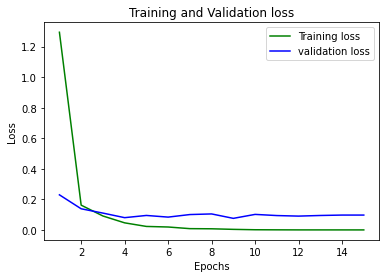

In [24]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,no_epochs+1)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

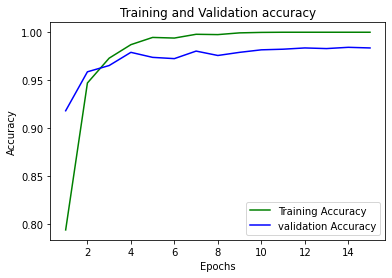

In [25]:
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(1,no_epochs+1)
plt.plot(epochs, loss_train, 'g', label='Training Accuracy')
plt.plot(epochs, loss_val, 'b', label='validation Accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [26]:


predictions = model.predict(X_test,batch_size=64, verbose=0)
y_classes = predictions.argmax(axis=-1)
cm = confusion_matrix(y_test, y_classes)
print(cm)

[[374   0   0   0]
 [  2 364  22   0]
 [  0   1 387   0]
 [  0   0   0 374]]


In [27]:
#to print confusion matrix
def print_cm(cm, labels, hide_zeroes=False, hide_diagonal=False, hide_threshold=None):
    """pretty print for confusion matrixes"""
    columnwidth = max([len(x) for x in labels] + [5])  # 5 is value length
    empty_cell = " " * columnwidth
    # Print header
    print("    " + empty_cell, end=" ")
    for label in labels:
        print("%{0}s".format(columnwidth) % label, end=" ")
    print()
    # Print rows
    for i, label1 in enumerate(labels):
        print("    %{0}s".format(columnwidth) % label1, end=" ")
        for j in range(len(labels)):
            cell = "%{0}.1f".format(columnwidth) % cm[i, j]
            if hide_zeroes:
                cell = cell if float(cm[i, j]) != 0 else empty_cell
            if hide_diagonal:
                cell = cell if i != j else empty_cell
            if hide_threshold:
                cell = cell if cm[i, j] > hide_threshold else empty_cell
            print(cell, end=" ")
        print()

# first generate with specified labels
cm = confusion_matrix(y_test, y_classes)
# then print it in a pretty way
print_cm(cm, category_list)

                        nut locatingpin        bolt      washer 
            nut       374.0         0.0         0.0         0.0 
    locatingpin         2.0       364.0        22.0         0.0 
           bolt         0.0         1.0       387.0         0.0 
         washer         0.0         0.0         0.0       374.0 


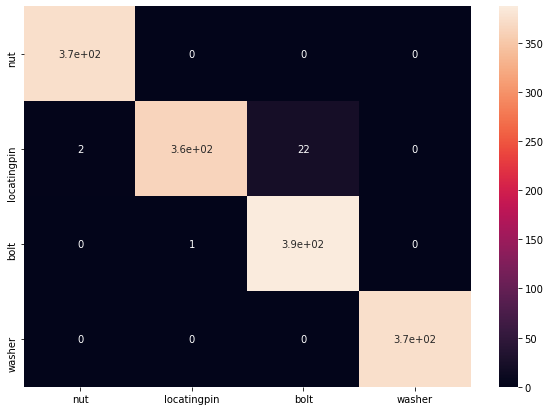

In [28]:
array = cm
df_cm = pd.DataFrame(array, index = [i for i in category_list],
                  columns = [i for i in category_list])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)